In [1]:
import cv2           # OpenCV (Open Source Computer Vision Library) it provides tools for computer vision taskes
                       # includes image and video processing, feature extraction, object detection, machine learning
import os              
from PIL import Image   #python image liberary 
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,log_loss , confusion_matrix ,roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
import random
import tensorflow as tf
from sklearn.metrics import accuracy_score, log_loss
from collections import Counter


In [2]:
# Write the Path of Your folder which contains Folderes that have images ,each name of these folders acts as the name of class (The images class name)
# Experiments_file here for example contains folders(AA,BB,CC) which contain images , so the first class name is AA for the first images class and BB for the second
class_directory = "C:\\Users\\Abdelrahman tawfik\\Desktop\\jupyter\\Image_datasets\\Image_datasets"

sift = cv2.SIFT_create()
all_keypoints = []
all_discriptors = []
all_labels = []
all_images = []
invalid_images_names = []
invalid_images_count=0

In [3]:
for class_name in os.listdir(class_directory):                                         #lists all folders in the specified directory. (The Class names)
    if class_name in ['Pepper__bell___Bacterial_spot', 'Potato___Early_blight', 'Potato___Late_blight']:
        class_path = os.path.join(class_directory,class_name)
        for file_name in os.listdir(class_path):                                           #lists all files in the specified directory. (the images)
            image_path = os.path.join(class_path,file_name)
            try:
                image = cv2.imread(image_path) 
                if image is None:
                    invalid_images_count=invalid_images_count+1
                else:
                    all_images.append(image)
                    label = os.path.basename(os.path.dirname(image_path))  
                    all_labels.append(label)
            except Exception as e:
                    invalid_images_count=invalid_images_count+1

let's explore if the categories balanced or not 

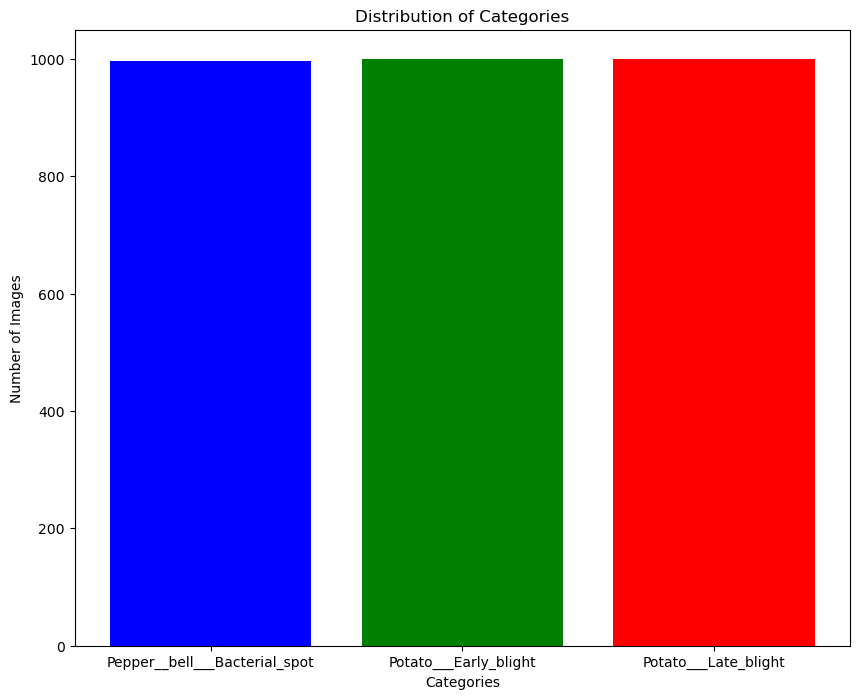

In [4]:
label_counts = Counter(all_labels)

# Plotting
labels = label_counts.keys()
counts = label_counts.values()

plt.figure(figsize=(10, 8))  # Adjust the figure size to make it larger
plt.bar(labels, counts, color=['blue', 'green', 'red'])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Categories')
plt.show()

checking the ratio of valid images to the invalid images 

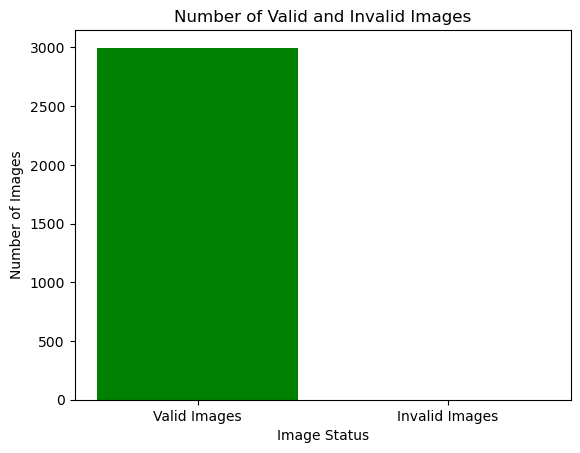

2997


In [5]:
labels = ['Valid Images', 'Invalid Images']
counts = [len(all_images), invalid_images_count]

plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Image Status')
plt.ylabel('Number of Images')
plt.title('Number of Valid and Invalid Images')
plt.show()
print(len(all_images))

checking the width and height of each image 

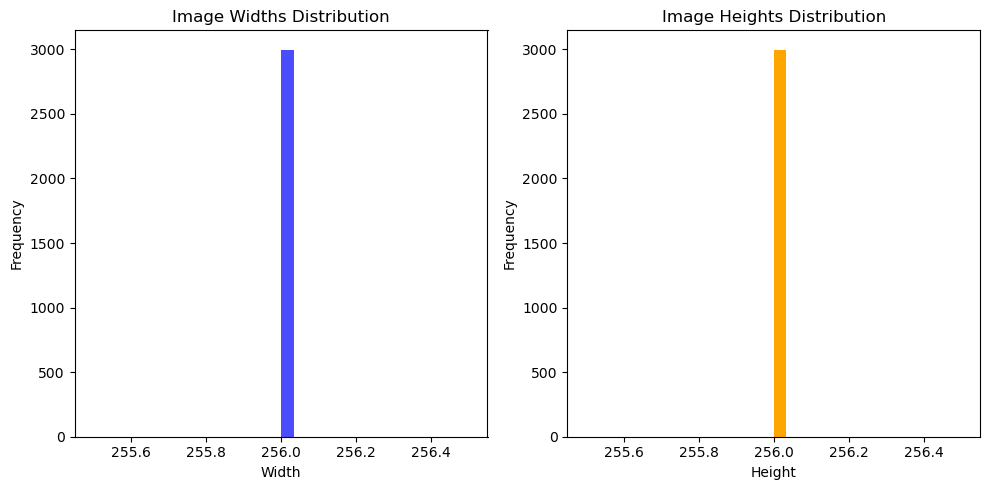

In [40]:
image_sizes = [img.shape for img in all_images]

widths = [size[1] for size in image_sizes]
heights = [size[0] for size in image_sizes]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue', alpha=0.7)
plt.title('Image Widths Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='orange')
plt.title('Image Heights Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

get the size of each image

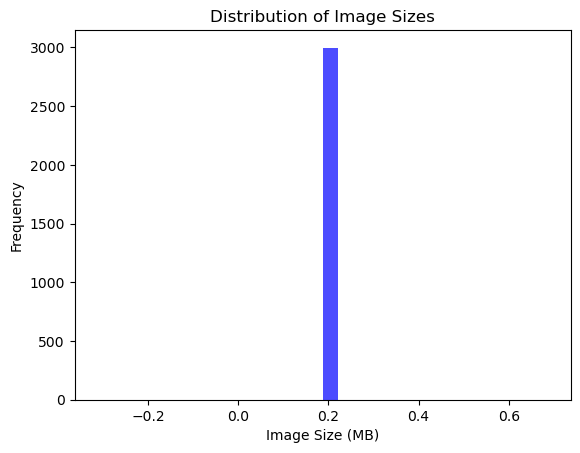

In [7]:
#getting the size of image in bytes then convert it to megabytes
image_sizes_mb = [img.nbytes / (1024 * 1024) for img in all_images]

plt.hist(image_sizes_mb, bins=30, color='blue', alpha=0.7)
plt.xlabel('Image Size (MB)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Sizes')
plt.show()

checking the number of channels in each image to know if they are grey or colored

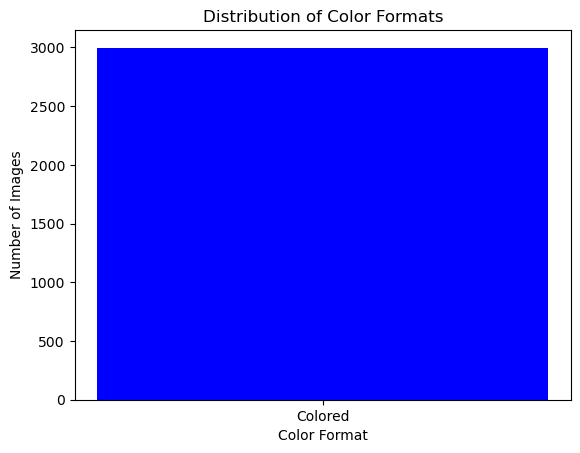

In [8]:

def check_color(image):
    # Check the number of color channels
    if len(image.shape) == 3 and image.shape[2] == 3:
        return 'Colored'
    elif len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        return 'Grayscale'
    else:
        return 'Unknown'

# Check color format for each image
color_formats = [check_color(img) for img in all_images]

color_counts = dict(zip(*np.unique(color_formats, return_counts=True)))

# Plot the distribution
colors = list(color_counts.keys())
counts = list(color_counts.values())

plt.bar(colors, counts, color=['blue', 'green'])
plt.xlabel('Color Format')
plt.ylabel('Number of Images')
plt.title('Distribution of Color Formats')
plt.show()

Looks like all the images are colored :)

now , we can say that we've done exploring our dataset !

Now let's convert the images to greyscale

In [9]:
grey_images = []

for image in all_images:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grey_images.append(gray_image)

print(len(grey_images))

2997


now let's see the difference !

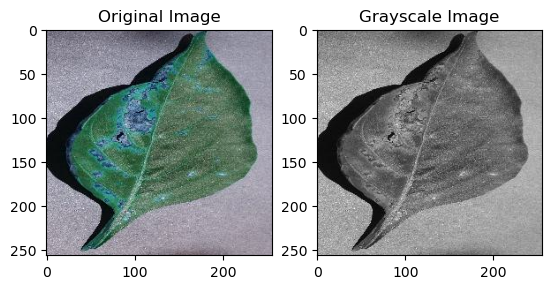

In [10]:

# Assuming 'all_images' is a list containing colored images
# and 'grey_images' is a list containing grayscale images

# Display the first colored image
plt.subplot(1, 2, 1)
plt.imshow(all_images[0])  # Convert BGR to RGB for proper display
plt.title('Original Image')

# Display the first grayscale image
plt.subplot(1, 2, 2)
plt.imshow(grey_images[0], cmap='gray')
plt.title('Grayscale Image')

plt.show()

now , let's apply SIFT for local feature extraction on the grey scaled images !

In [11]:
# Lists to store the number of keypoints and dimension of descriptors for each image
num_keypoints_list = []
descriptor_dimension_list = []

for i in range(len(grey_images)):
    keypoints, descriptors = sift.detectAndCompute(grey_images[i], None)

    # Check if both keypoints and descriptors are not None
    if keypoints is not None and descriptors is not None:
        # Append only if both keypoints and descriptors are not None
        all_keypoints.append(keypoints)
        all_discriptors.append(descriptors)
        num_keypoints_list.append(len(keypoints))
        descriptor_dimension_list.append(descriptors.shape[1])
    else:
        # Handle the case where either keypoints or descriptors is None
        # You can choose to skip this image or handle it differently
        print(f"Skipping image {i} because keypoints or descriptors is None.")


In [12]:
average_num_keypoints = sum(num_keypoints_list) / len(num_keypoints_list)
average_descriptor_dimension = sum(descriptor_dimension_list) / len(descriptor_dimension_list)

# Print the averages
print(f"Average number of keypoints: {average_num_keypoints}")
print(f"Average dimension of descriptors: {average_descriptor_dimension}")


Average number of keypoints: 366.45512178845513
Average dimension of descriptors: 128.0


now let's take a look !

2997
2997


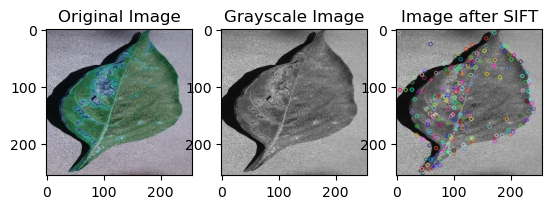

In [13]:
print(len(all_keypoints))
print(len(all_discriptors))
plt.subplot(1, 3, 1)
plt.imshow(all_images[0])
plt.title('Original Image')

# Display the grayscale image
plt.subplot(1, 3, 2)
plt.imshow(grey_images[0], cmap='gray')
plt.title('Grayscale Image')

# Apply SIFT to the grayscale image
# Display the result after using SIFT
plt.subplot(1, 3, 3)
plt.imshow(cv2.drawKeypoints(grey_images[0], all_keypoints[0], None,))
plt.title('Image after SIFT')

plt.show()

checking if all the images have discriptors and keypoints or not 

In [14]:
filtered_images = []
filtered_labels = []
filtered_keypoints = []
filtered_descriptors = []

# Iterate through the data
for i in range(len(all_discriptors)):
    descriptors = all_discriptors[i]

    # Check if descriptors are not None (i.e., not empty)
    if descriptors is not None:
        # Append non-empty data to filtered lists
        filtered_images.append(grey_images[i])
        filtered_labels.append(all_labels[i])
        filtered_keypoints.append(all_keypoints[i])
        filtered_descriptors.append(descriptors)

# Update your original lists with the filtered data
grey_images = filtered_images
all_labels = filtered_labels
all_keypoints = filtered_keypoints
all_discriptors = filtered_descriptors

In [15]:
print(len(all_keypoints))
print(len(all_discriptors))
print(len(all_labels))

2997
2997
2997


looks like all is good !!!

# let's start training the model !

In [16]:
# Combine the data into a single list of tuples
combined_data = list(zip(all_discriptors, all_labels, grey_images, all_keypoints))

# Shuffle the combined data
random.shuffle(combined_data)

# Unpack the shuffled data into separate lists
shuffled_descriptors, shuffled_labels, shuffled_images, shuffled_keypoints = zip(*combined_data)


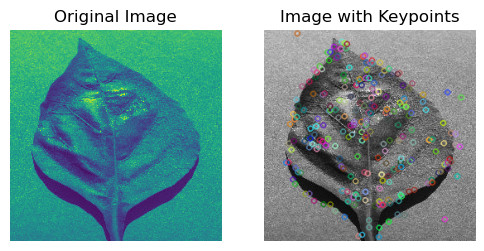

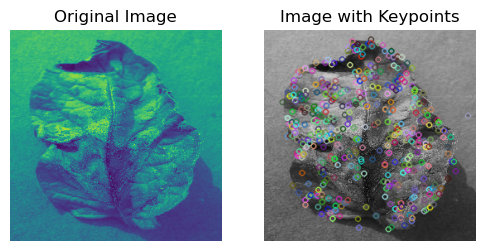

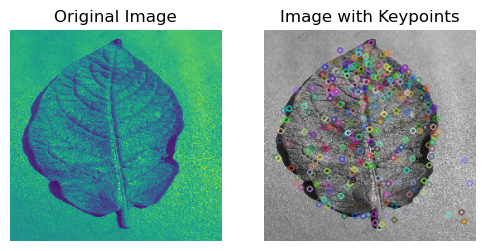

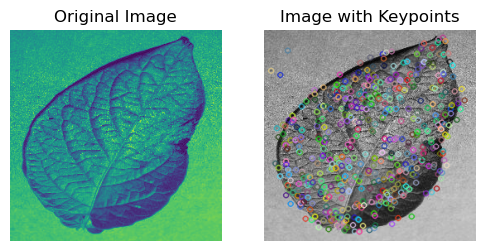

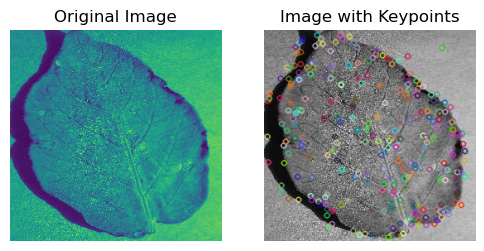

In [17]:
#display the Keypoints on the first 5 images after shuffling
for i in range (5):
    # Visualize ORB keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(shuffled_images[i], shuffled_keypoints[i], None)
    # Display the keypoints on the original point 
    plt.figure(figsize=(6, 3))
    plt.subplot(121), plt.imshow(shuffled_images[i]), plt.title('Original Image') , plt.axis('off')
    plt.subplot(122), plt.imshow(image_with_keypoints), plt.title('Image with Keypoints') , plt.axis('off')
    plt.show()

In [18]:
# Convert the labels to numerical values
label_mapping = {label: i for i, label in enumerate(np.unique(shuffled_labels))}
all_labels_numeric = np.array([label_mapping[label] for label in shuffled_labels])

In [19]:
# Pad all_descriptors to a fixed lenght
padded_discriptors=pad_sequences(shuffled_descriptors, maxlen=750, padding='post' ,truncating='post' ,dtype= 'float32' )
# Is using NumPy's reshape function to transform a multi-dimensional array into a two-dimensional array 
# Multi_demensional (which gonna be converted) is assumed to be a multi-dimensional NumPy array to success the conversion 
flattened_discriptors = padded_discriptors.reshape((len(padded_discriptors), -1))     #This tuple specifies the target shape of the array in the first dimension and the second
# -1 it means that the size of that dimension (second dimension) is inferred based on the size of the array and the other specified dimensions

In [20]:
# Convert the all_descriptors list to numpy array 
X = np.array(flattened_discriptors)                       #To covert it must all the dimensions has the same sizeeeeeeeeee  {ERROR}
y = all_labels_numeric

In [21]:
# Split Test and Target Datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in testing set: {len(X_test)}")

Number of samples in training set: 2397
Number of samples in testing set: 600


In [23]:
# Scaling the feature datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs' ,max_iter=2000)

In [25]:
# Train the model
logistic.fit(X_train,y_train)

LogisticRegression(max_iter=2000, multi_class='multinomial')

In [26]:
# Check convergence inf
print("Convergence number:", logistic.n_iter_)                

Convergence number: [362]


In [27]:
# Predict the target for test dataset
y_pred = logistic.predict(X_test)
y_pred_proba = logistic.predict_proba(X_test)       #generate the predicted probabilities for each class (or label) for each sample

In [28]:
# Calculate the accuracy
accuracy = accuracy_score(y_test,y_pred)
print(f"The accuracy : {accuracy}")

The accuracy : 0.8133333333333334


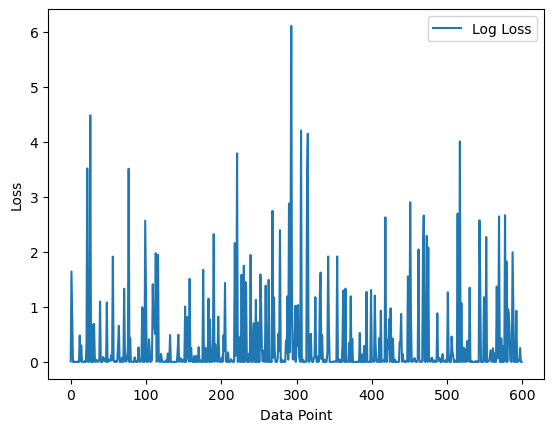

In [29]:
# Calculate log loss 
loss_values = []
for i in range(len(y_test)):
    true_label = np.zeros(len(label_mapping))
    true_label[y_test[i]] = 1
    loss = log_loss(true_label, y_pred_proba[i])
    loss_values.append(loss)

# Plotting the loss curve
plt.plot(loss_values, label='Log Loss')
plt.xlabel('Data Point')
plt.ylabel('Loss')
plt.legend()
plt.show()

#  Loss curve referred to as the training loss curve (loss function) and The goal during training is to minimize this loss J(O)

Confusion Matrix:
[[171   8  15]
 [  6 177  30]
 [ 20  33 140]]


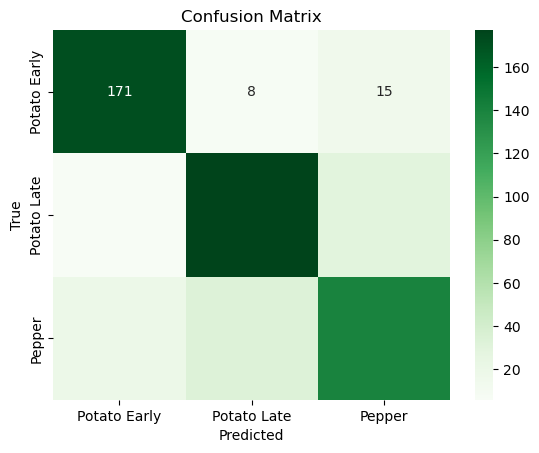

In [30]:
# Confusion Matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)
# Visualize the confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=['Potato Early', 'Potato Late', 'Pepper'], yticklabels=['Potato Early', 'Potato Late', 'Pepper'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

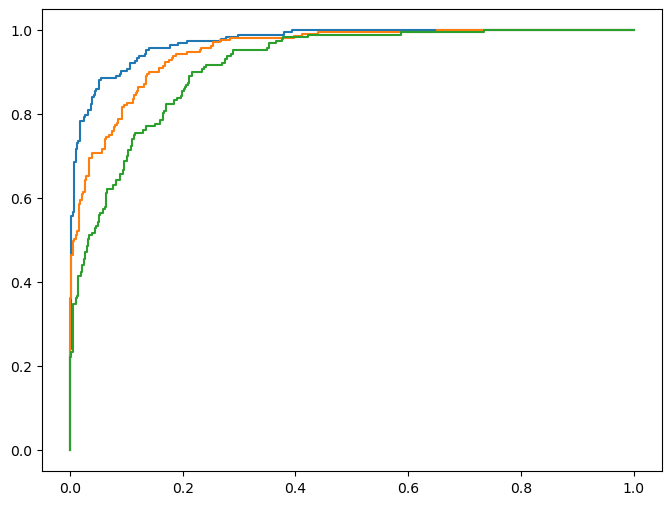

In [34]:
# Binarize the labels for the ROC curve
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))                  #is used to convert the true labels into binary format for the ROC curve.
# Compute ROC curve and ROC area for each class
#plots the True Positive Rate (sensitivity) against the False Positive Rate (1 - specificity) for various threshold values.
# Threshold values convert the continuous probability scores produced by a model into binary predictions. In the context of a binary classification problem, these probability scores can be compared to a threshold to determine the predicted class.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])          # Roc_curve computes the ROC curve for each class.
    roc_auc[i] = auc(fpr[i], tpr[i])                                             # Auc  calculates the area under the ROC curve for each class

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# k_means Algorithm !

## **Main Alg** (scalling + dimentionality reducion + kmeans)

In [35]:
X = np.array(flattened_discriptors)

In [36]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction (PCA)
pca = PCA(n_components=0.7)
X_reduced = pca.fit_transform(X_scaled)

# Number of clusters
K = 3

# Creating the model
kmeans_model = KMeans(n_clusters=K, random_state=42)

# Training the model, and assigning the pridections to y_pred
y_pred = kmeans_model.fit_predict(X_reduced)



E:\Disktop\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\Disktop\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


## **Accuracy Score**

In [37]:
from sklearn.metrics import silhouette_score
print(silhouette_score(X_reduced, y_pred))

0.33348006
